In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/olid-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/and/.cache/kagglehub/datasets/feyzazkefe/olid-dataset/versions/1


In [20]:
!pip install kagglehub

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/and/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f'Device {i} name:', torch.cuda.get_device_name(i))

CUDA available True
CUDA version 12.1
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce RTX 4070 Laptop GPU


# Base

In [30]:
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.1, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

In [31]:
df.count()

Content    72612
Label      72612
dtype: int64

In [32]:
def preprocess(text):
    return word_tokenize(text.lower())

In [33]:
df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [34]:
# Функція для валідації моделі
def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Функція для тестування моделі з виведенням матриці неточностей
def test_model_with_report_and_confusion_matrix(model, test_loader, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"../models/{model_name}_confusion_matrix.png")
    plt.show()

# Візуалізація графіків втрат і точності
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name='model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../models/{model_name}_metrics.png")
    plt.show()

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        # Додаємо прогрес-бар для тестування
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())  # Використовуємо .tolist() замість numpy
    return all_preds

# Complex

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Complex xLSTM Configuration with Additional Layers
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=8  # Increased number of heads for complexity
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=8,  # Increase for complexity
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.5, act_fn="gelu"),  # Higher proj_factor
    ),
    context_length=MAX_LEN,
    num_blocks=8,  # Increased number of blocks
    embedding_dim=128,
    slstm_at=[1, 3, 5],  # Apply slstm at multiple layers
)

# Initialize the xLSTM stack
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Complex HateSpeechModel with More xLSTM Layers and Fully Connected Layers
class ComplexHateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim=128, dropout_prob=0.5):
        super(ComplexHateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Stacking multiple xLSTM layers
        self.xlstm_stack1 = xlstm_stack
        self.xlstm_stack2 = xLSTMBlockStack(cfg).to("cuda")
        self.xlstm_stack3 = xLSTMBlockStack(cfg).to("cuda")

        # Dropout for regularization
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)

        # Fully connected layers for increased model capacity
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Output layer for binary classification

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)

        # Pass through multiple xLSTM layers
        x = self.xlstm_stack1(x)
        x = self.dropout1(x)
        x = self.xlstm_stack2(x)
        x = self.dropout2(x)
        x = self.xlstm_stack3(x)
        x = self.dropout3(x)

        # Fully connected layers
        x = torch.relu(self.fc1(x.mean(dim=1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/and/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/7] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda_error.cuda.o.d -DTORCH_EXTENSION_NAME=slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/TH -isystem /home/and/miniconda3/envs/venv/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/and/miniconda3/envs/venv/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_89,code=compute

Loading extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:546: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, training, *inputs):
/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/cell.py:571: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_s):
Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=8', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /home/and/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH8NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


In [37]:
# Initialize the complex model
model = ComplexHateSpeechModel(xlstm_stack, vocab_size, embedding_dim=128, dropout_prob=0.5).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Train the model as before
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Evaluate the updated model
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Updated Complex Model Accuracy: {accuracy:.4f}')

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:08<00:00,  3.65it/s]


Epoch [1/10], Loss: 0.5788, Accuracy: 0.6820, Val Loss: 0.5158, Val Accuracy: 0.7521


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:07<00:00,  3.66it/s]


Epoch [2/10], Loss: 0.4645, Accuracy: 0.7763, Val Loss: 0.4712, Val Accuracy: 0.7902


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:08<00:00,  3.65it/s]


Epoch [3/10], Loss: 0.4100, Accuracy: 0.8093, Val Loss: 0.4505, Val Accuracy: 0.7989


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:09<00:00,  3.64it/s]


Epoch [4/10], Loss: 0.3694, Accuracy: 0.8323, Val Loss: 0.4564, Val Accuracy: 0.8022


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:07<00:00,  3.66it/s]


Epoch [5/10], Loss: 0.3343, Accuracy: 0.8528, Val Loss: 0.4457, Val Accuracy: 0.8154


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:08<00:00,  3.65it/s]


Epoch [6/10], Loss: 0.2974, Accuracy: 0.8717, Val Loss: 0.4787, Val Accuracy: 0.8130


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:08<00:00,  3.66it/s]


Epoch [7/10], Loss: 0.2565, Accuracy: 0.8936, Val Loss: 0.5016, Val Accuracy: 0.8127


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 908/908 [04:08<00:00,  3.65it/s]


Epoch [8/10], Loss: 0.2134, Accuracy: 0.9146, Val Loss: 0.5555, Val Accuracy: 0.8097
Early stopping triggered


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:15<00:00, 14.53it/s]

Updated Complex Model Accuracy: 0.8097


# Model 1

In [65]:
path_to_dataset = "../datasets/FinalBalancedDataset.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.5, random_state=42) 


content_lbl, class_lbl = 'tweet', 'Toxicity'
df = df[[content_lbl, class_lbl]]
df = df[df[class_lbl] != 2]
def preprocess(text):
    return word_tokenize(text.lower())
    
df[content_lbl] = df[content_lbl].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df[content_lbl] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df[content_lbl] = train_df[content_lbl].apply(encode_tweet)
test_df[content_lbl] = test_df[content_lbl].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df[content_lbl], MAX_LEN)
X_test = pad_sequences(test_df[content_lbl], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df[class_lbl])
y_test = le.transform(test_df[class_lbl])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [66]:
df.count()

tweet       28372
Toxicity    28372
dtype: int64

In [67]:
# result = df.groupby('Toxicity').size().reset_index(name='Toxicity@')

In [68]:
result

,Toxicity,Toxicity@
0,0,16254
1,1,12118


In [69]:
df.head()

,tweet,Toxicity
44200,"[kim, k, is, alright, but, honestly, so, many,...",1
46339,"[rt, @, bigjonbul, :, the, stars, wink, knowin...",0
49169,"[rt, @, sassymermaidxo, :, &, #, 8220, ;, @, v...",1
54130,"[those, ``, tell, me, about, yourself, ``, loo...",1
18801,"[4, days, ago, ..., to, celebrate, #, national...",0


In [82]:
# Оновлена конфігурація xLSTM з підвищеною регуляризацією
cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=MAX_LEN,
    num_blocks=5,  # Зменшення кількості блоків для зменшення складності моделі
    embedding_dim=128,
    slstm_at=[1],
)

# Ініціалізація xLSTM стеку
xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

# Модель з Dropout і L2-регуляризацією
class HateSpeechModel(nn.Module):
    def __init__(self, xlstm_stack, vocab_size, embedding_dim, dropout_prob=0.6):  # Збільшений Dropout
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.xlstm = xlstm_stack
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)

    def forward(self, x):  
        x = self.embedding(x)
        x = self.xlstm(x)
        x = self.dropout(x)
        x = self.fc(x.mean(dim=1))
        return x

# Ініціалізація моделі
model = HateSpeechModel(xlstm_stack, vocab_size, 128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)  # Додана L2-регуляризація

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:  # Додаємо перевірку довжини списку
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Навчання моделі з раннім зупиненням
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Валідація
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Раннє зупинення
        if early_stopping(val_losses):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [83]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=40)

Epoch 1/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.35it/s]


Epoch [1/40], Loss: 0.6161, Accuracy: 0.6437, Val Loss: 0.4691, Val Accuracy: 0.7808


Epoch 2/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.55it/s]


Epoch [2/40], Loss: 0.3928, Accuracy: 0.8334, Val Loss: 0.3735, Val Accuracy: 0.8481


Epoch 3/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.21it/s]


Epoch [3/40], Loss: 0.3527, Accuracy: 0.8587, Val Loss: 0.3520, Val Accuracy: 0.8590


Epoch 4/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.30it/s]


Epoch [4/40], Loss: 0.3314, Accuracy: 0.8686, Val Loss: 0.3353, Val Accuracy: 0.8648


Epoch 5/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.28it/s]


Epoch [5/40], Loss: 0.3042, Accuracy: 0.8813, Val Loss: 0.3037, Val Accuracy: 0.8833


Epoch 6/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.30it/s]


Epoch [6/40], Loss: 0.2927, Accuracy: 0.8865, Val Loss: 0.2990, Val Accuracy: 0.8837


Epoch 7/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [7/40], Loss: 0.2857, Accuracy: 0.8896, Val Loss: 0.2947, Val Accuracy: 0.8855


Epoch 8/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.28it/s]


Epoch [8/40], Loss: 0.2815, Accuracy: 0.8907, Val Loss: 0.2956, Val Accuracy: 0.8878


Epoch 9/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [9/40], Loss: 0.2766, Accuracy: 0.8921, Val Loss: 0.2868, Val Accuracy: 0.8890


Epoch 10/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.32it/s]


Epoch [10/40], Loss: 0.2722, Accuracy: 0.8951, Val Loss: 0.2826, Val Accuracy: 0.8904


Epoch 11/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.22it/s]


Epoch [11/40], Loss: 0.2667, Accuracy: 0.8982, Val Loss: 0.2785, Val Accuracy: 0.8929


Epoch 12/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [12/40], Loss: 0.2625, Accuracy: 0.8996, Val Loss: 0.2762, Val Accuracy: 0.8946


Epoch 13/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [13/40], Loss: 0.2596, Accuracy: 0.8999, Val Loss: 0.2756, Val Accuracy: 0.8960


Epoch 14/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.27it/s]


Epoch [14/40], Loss: 0.2570, Accuracy: 0.9012, Val Loss: 0.2736, Val Accuracy: 0.8946


Epoch 15/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [15/40], Loss: 0.2528, Accuracy: 0.9041, Val Loss: 0.2817, Val Accuracy: 0.8895


Epoch 16/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.33it/s]


Epoch [16/40], Loss: 0.2506, Accuracy: 0.9041, Val Loss: 0.2685, Val Accuracy: 0.8953


Epoch 17/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [17/40], Loss: 0.2483, Accuracy: 0.9064, Val Loss: 0.2689, Val Accuracy: 0.8981


Epoch 18/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.30it/s]


Epoch [18/40], Loss: 0.2458, Accuracy: 0.9068, Val Loss: 0.2650, Val Accuracy: 0.8967


Epoch 19/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.33it/s]


Epoch [19/40], Loss: 0.2440, Accuracy: 0.9083, Val Loss: 0.2711, Val Accuracy: 0.8946


Epoch 20/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [20/40], Loss: 0.2410, Accuracy: 0.9091, Val Loss: 0.2653, Val Accuracy: 0.8962


Epoch 21/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.27it/s]


Epoch [21/40], Loss: 0.2388, Accuracy: 0.9093, Val Loss: 0.2611, Val Accuracy: 0.8974


Epoch 22/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.13it/s]


Epoch [22/40], Loss: 0.2366, Accuracy: 0.9111, Val Loss: 0.2603, Val Accuracy: 0.8981


Epoch 23/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [23/40], Loss: 0.2346, Accuracy: 0.9104, Val Loss: 0.2604, Val Accuracy: 0.9004


Epoch 24/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [24/40], Loss: 0.2335, Accuracy: 0.9116, Val Loss: 0.2648, Val Accuracy: 0.8981


Epoch 25/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.17it/s]


Epoch [25/40], Loss: 0.2313, Accuracy: 0.9130, Val Loss: 0.2543, Val Accuracy: 0.8996


Epoch 26/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.53it/s]


Epoch [26/40], Loss: 0.2292, Accuracy: 0.9139, Val Loss: 0.2592, Val Accuracy: 0.8990


Epoch 27/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [27/40], Loss: 0.2267, Accuracy: 0.9140, Val Loss: 0.2555, Val Accuracy: 0.9004


Epoch 28/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [28/40], Loss: 0.2244, Accuracy: 0.9148, Val Loss: 0.2599, Val Accuracy: 0.9010


Epoch 29/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.26it/s]


Epoch [29/40], Loss: 0.2218, Accuracy: 0.9161, Val Loss: 0.2581, Val Accuracy: 0.8985


Epoch 30/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.26it/s]


Epoch [30/40], Loss: 0.2223, Accuracy: 0.9147, Val Loss: 0.2513, Val Accuracy: 0.8999


Epoch 31/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.23it/s]


Epoch [31/40], Loss: 0.2193, Accuracy: 0.9172, Val Loss: 0.2469, Val Accuracy: 0.9047


Epoch 32/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.26it/s]


Epoch [32/40], Loss: 0.2165, Accuracy: 0.9183, Val Loss: 0.2472, Val Accuracy: 0.9020


Epoch 33/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.23it/s]


Epoch [33/40], Loss: 0.2146, Accuracy: 0.9194, Val Loss: 0.2513, Val Accuracy: 0.9054


Epoch 34/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.17it/s]


Epoch [34/40], Loss: 0.2135, Accuracy: 0.9188, Val Loss: 0.2442, Val Accuracy: 0.9033


Epoch 35/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [35/40], Loss: 0.2104, Accuracy: 0.9211, Val Loss: 0.2494, Val Accuracy: 0.9033


Epoch 36/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.24it/s]


Epoch [36/40], Loss: 0.2093, Accuracy: 0.9218, Val Loss: 0.2453, Val Accuracy: 0.9036


Epoch 37/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [37/40], Loss: 0.2081, Accuracy: 0.9209, Val Loss: 0.2404, Val Accuracy: 0.9057


Epoch 38/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.31it/s]


Epoch [38/40], Loss: 0.2061, Accuracy: 0.9217, Val Loss: 0.2490, Val Accuracy: 0.9027


Epoch 39/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.29it/s]


Epoch [39/40], Loss: 0.2038, Accuracy: 0.9240, Val Loss: 0.2390, Val Accuracy: 0.9064


Epoch 40/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:18<00:00, 19.15it/s]


Epoch [40/40], Loss: 0.2033, Accuracy: 0.9238, Val Loss: 0.2395, Val Accuracy: 0.9054


## History

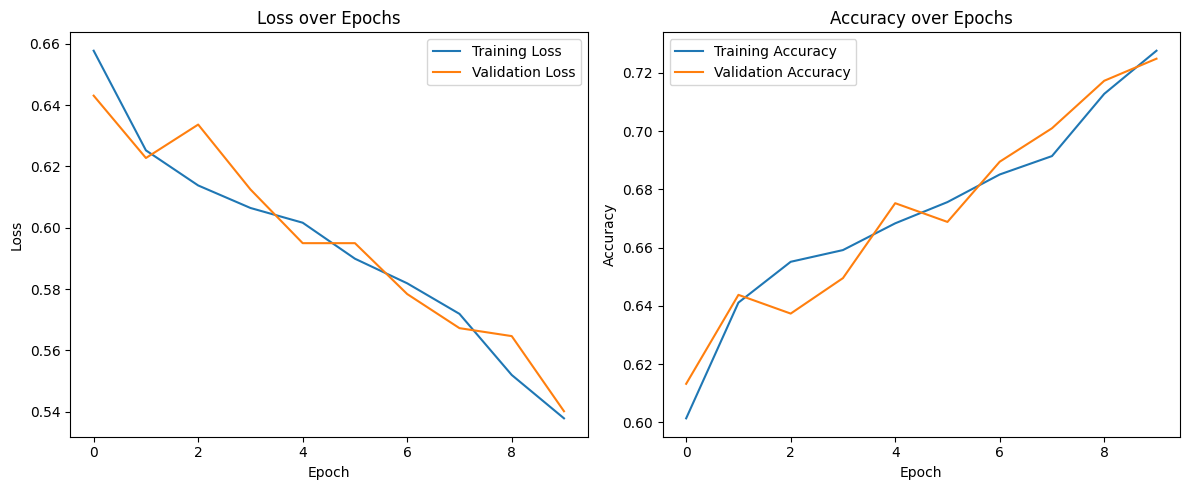

In [44]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

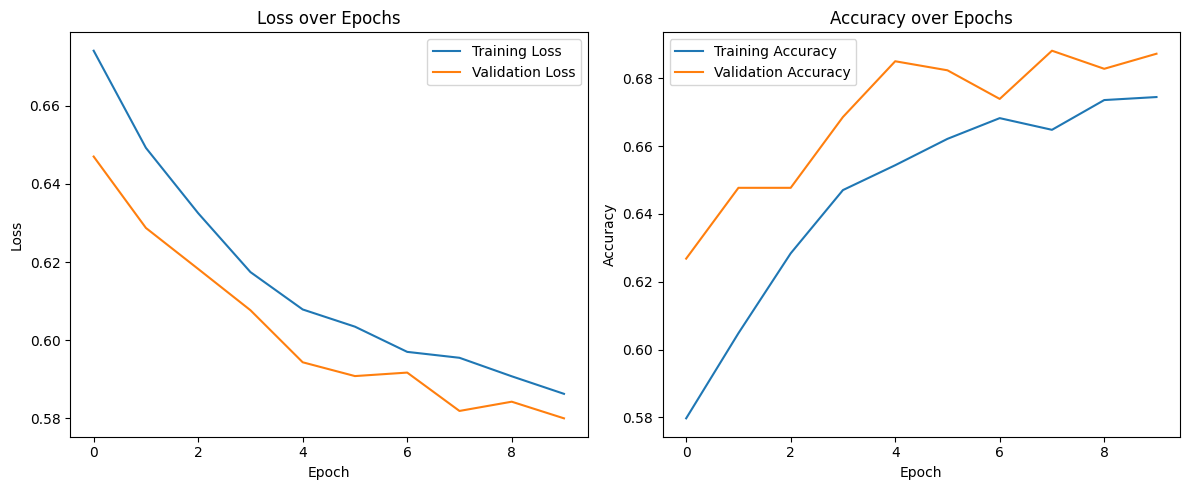

In [120]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

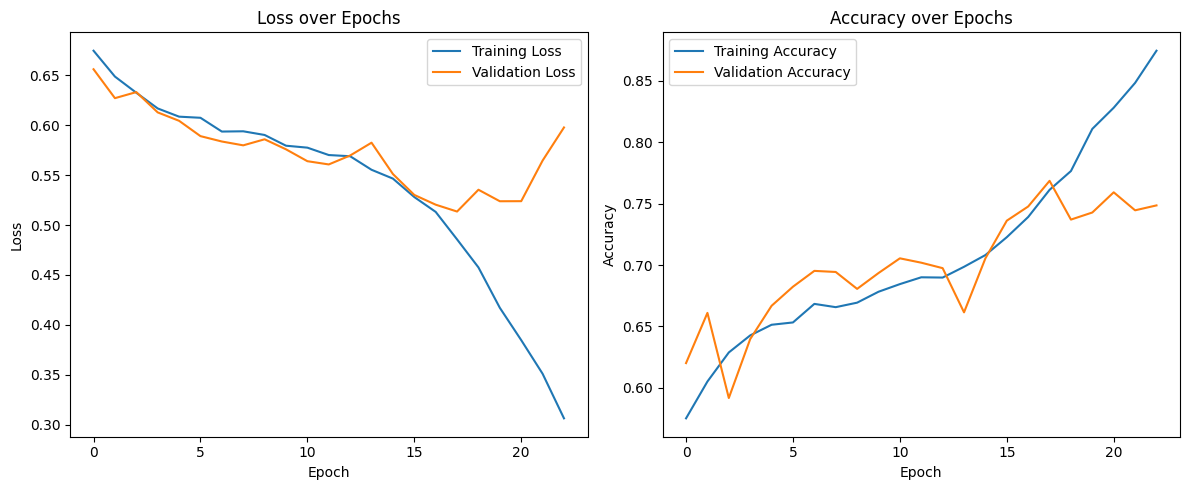

In [123]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)  # Accuracy: 0.7486

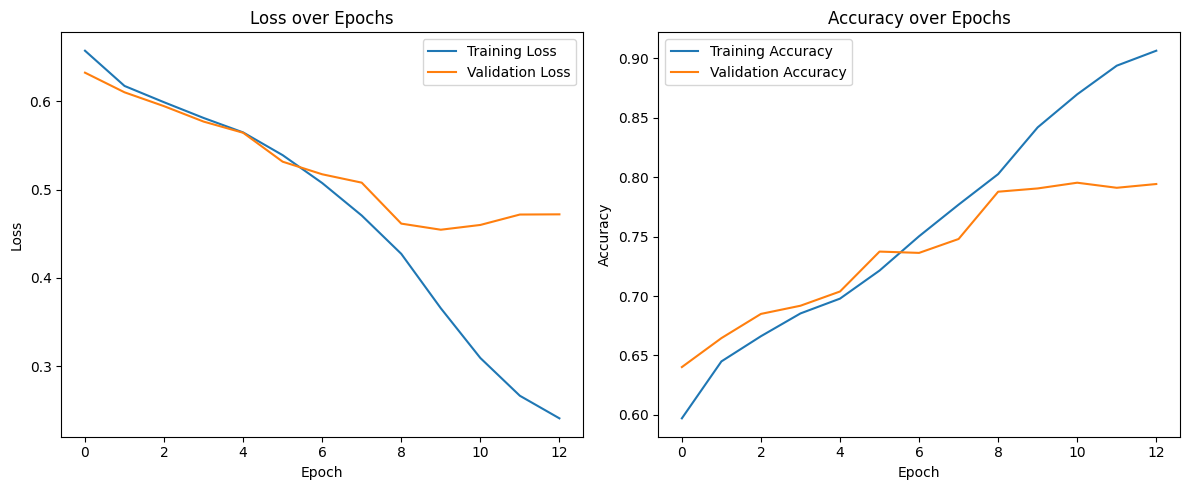

In [132]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)  # Accuracy: 0.7943

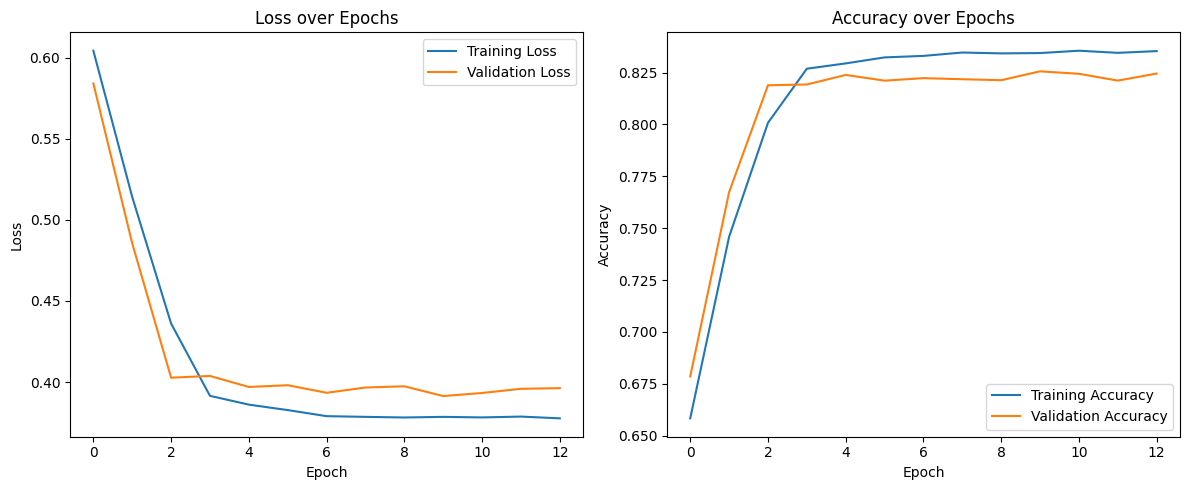

In [142]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)  # Accuracy: 0.8245

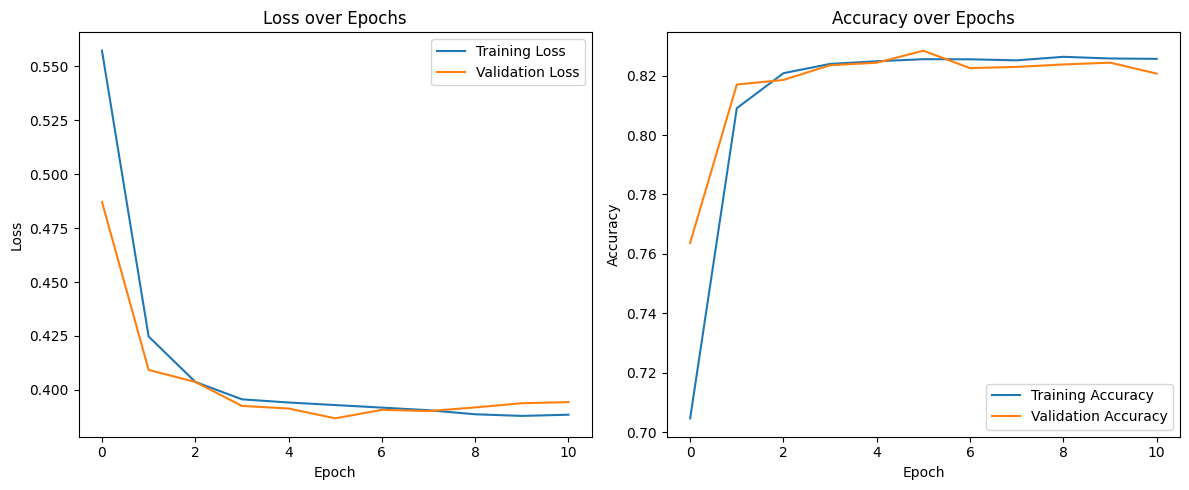

In [153]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)  # 0.8207 0.5

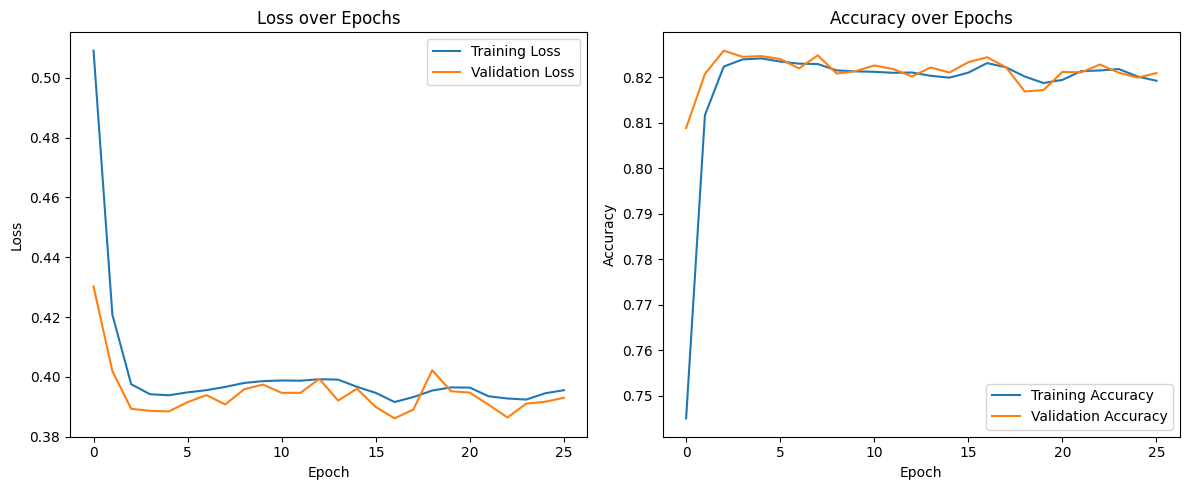

In [162]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

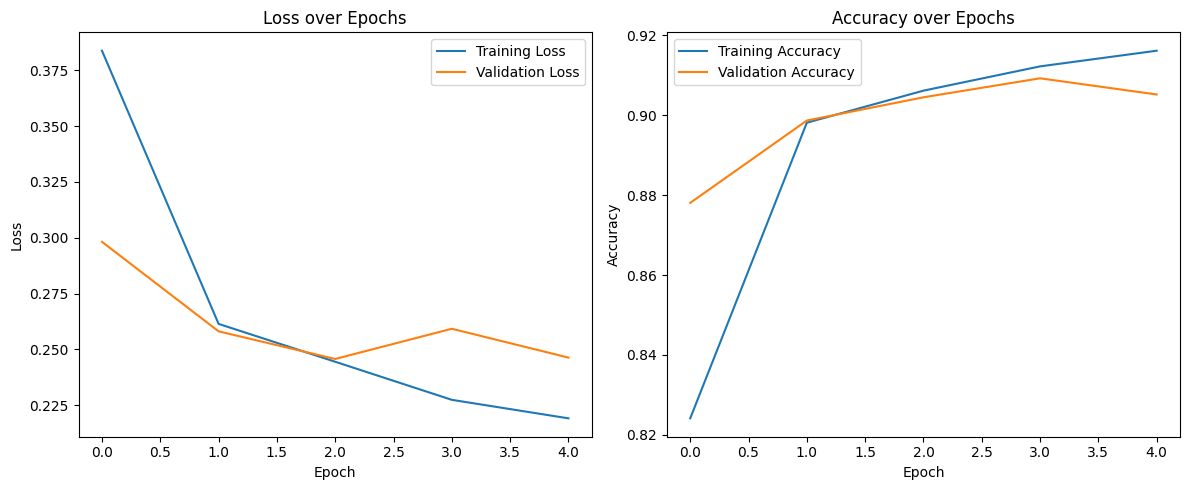

In [64]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## New History

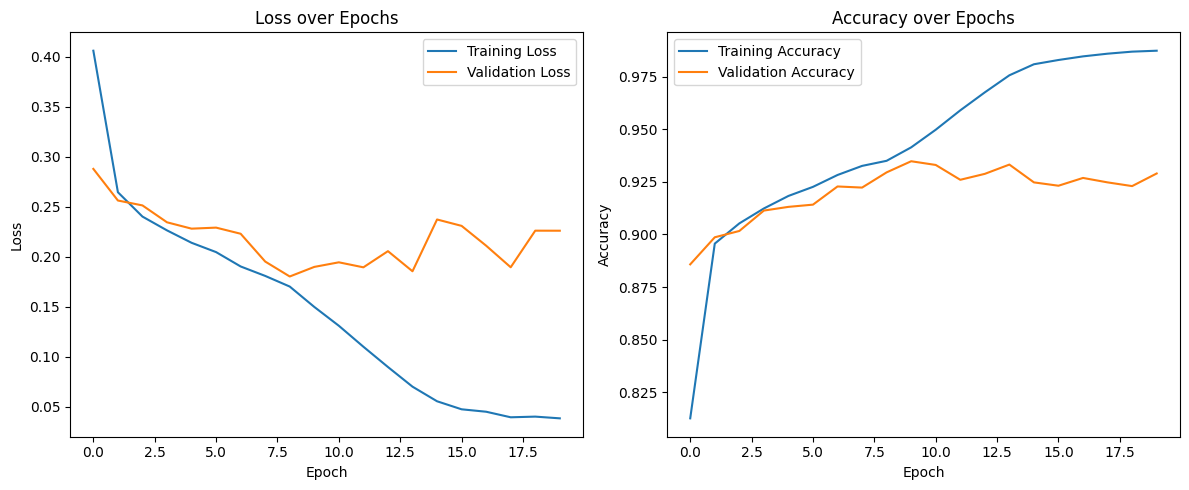

In [72]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies) # 0.9290 lr 0.001

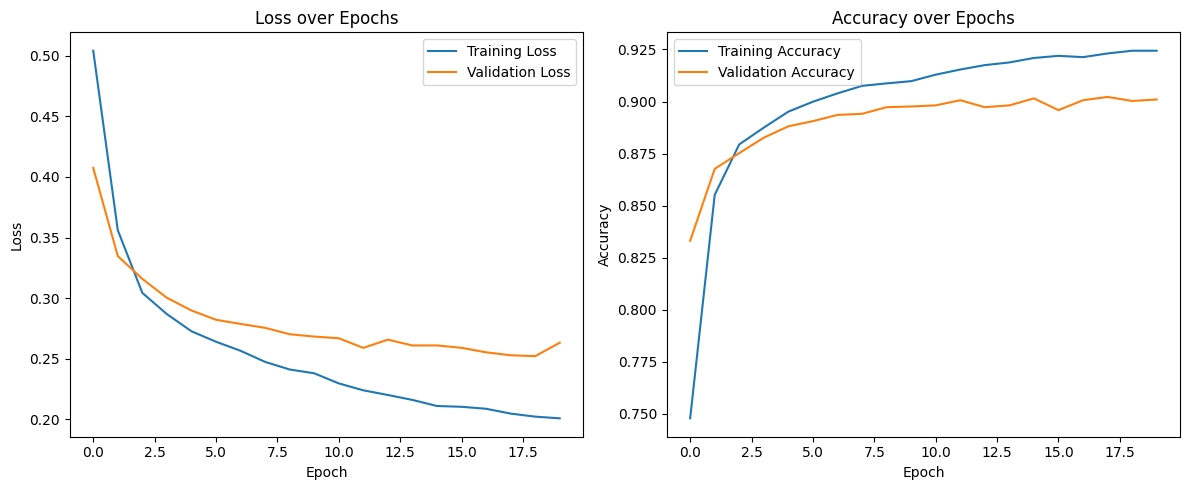

In [78]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)  # 0.9010 0.0001

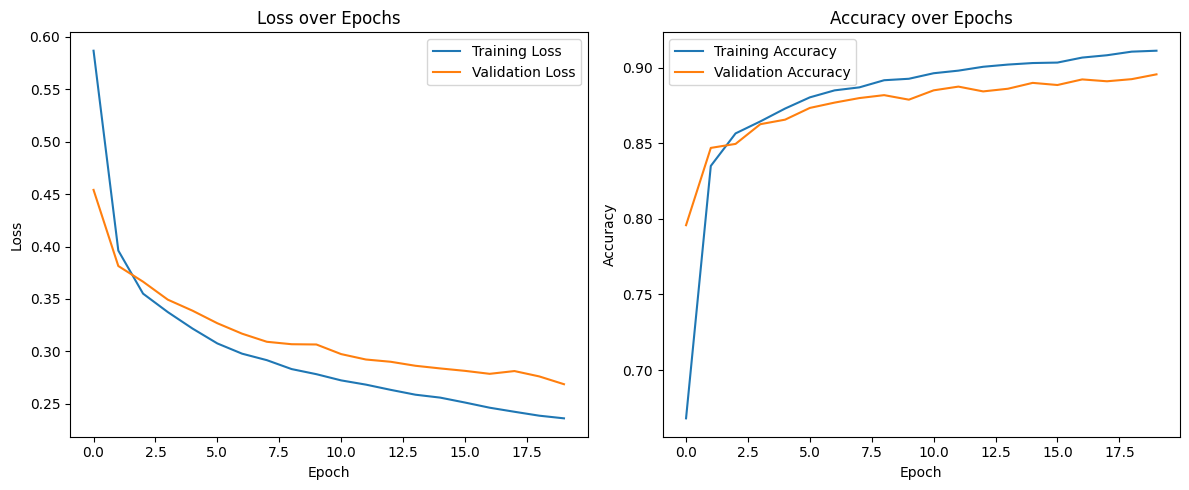

In [81]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies) # 0.8988 lr 0.0005 epochs 20

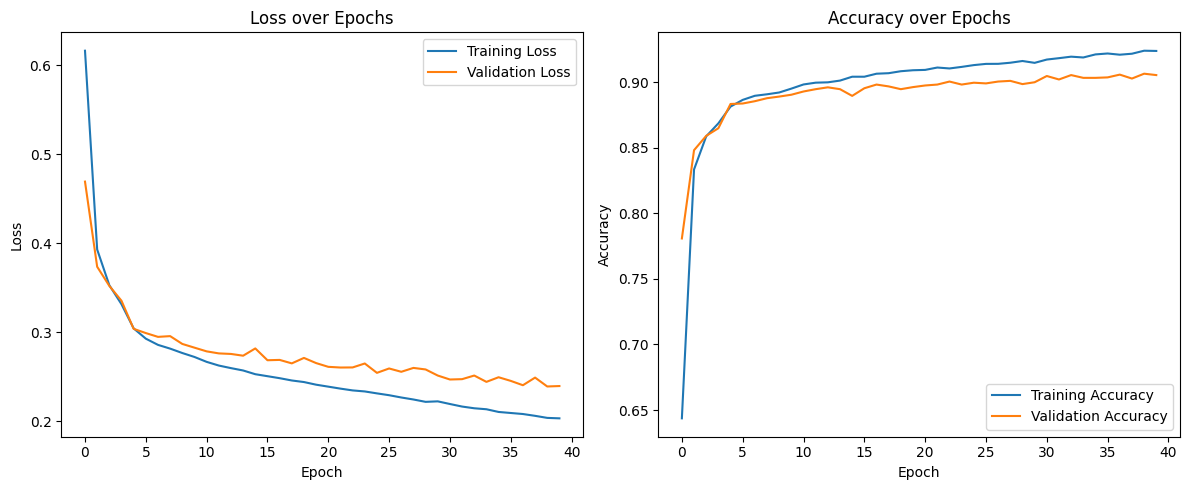

In [84]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies) # 0.9054 lr 0.0005 epochs 40

In [85]:
preds = test_model(model, test_loader)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:01<00:00, 63.70it/s]

Accuracy: 0.9054


# Optuna 2

In [15]:
import optuna
import time
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from prettytable import PrettyTable

# Track trial details
trial_results = []

# Define objective function for Optuna
def objective(trial):
    start_time = time.time()
    
    # Hyperparameters to tune
    dropout_prob = trial.suggest_float("dropout_prob", 0.3, 0.7, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 0.1)

    # Model initialization with trial parameters
    model = HateSpeechModel(xlstm_stack, vocab_size, 128, dropout_prob).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Early stopping settings
    patience = 3
    val_losses = []

    # Training loop limited to 10 epochs
    for epoch in range(10):
        model.train()
        total_loss = 0
        with tqdm(train_loader, desc=f'Trial {trial.number+1}, Epoch {epoch+1}/10', leave=False) as pbar:
            for tweets, labels in pbar:
                tweets, labels = tweets.to("cuda"), labels.to("cuda")
                optimizer.zero_grad()
                outputs = model(tweets)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
        # Validation
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)

        # Early stopping check
        if early_stopping(val_losses, patience):
            break

    # Evaluate accuracy on the test set after training
    preds = test_model(model, test_loader)
    accuracy = accuracy_score(y_test, preds)

    # Track trial time and results
    trial_time = time.time() - start_time
    trial_results.append({
        "Trial": trial.number + 1,
        "Time (s)": f"{trial_time:.2f}",
        "Accuracy": f"{accuracy:.4f}"
    })

    return accuracy

In [17]:
# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-10-31 18:36:26,877] A new study created in memory with name: no-name-3f112f37-a303-4c1a-928c-362f4b63aa1a
/tmp/ipykernel_15989/257899659.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_15989/257899659.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 0.1)
Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:02<00:00, 80.31it/s]
[I 2024-10-31 18:44:40,102] Trial 0 

In [18]:
# Display results as table
table = PrettyTable(["Trial", "Time (s)", "Accuracy"])
for result in trial_results:
    table.add_row([result["Trial"], result["Time (s)"], result["Accuracy"]])

In [19]:
print("Trial Results Summary:")
print(table)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Trial Results Summary:
+-------+----------+----------+
| Trial | Time (s) | Accuracy |
+-------+----------+----------+
|   1   |  493.22  |  0.6443  |
|   2   |  493.72  |  0.7265  |
|   3   |  510.60  |  0.7580  |
|   4   |  492.65  |  0.7779  |
|   5   |  443.30  |  0.8122  |
+-------+----------+----------+
Best hyperparameters: {'dropout_prob': 0.5, 'lr': 0.0006338197982779089, 'weight_decay': 0.0006313156245175037}
Best accuracy: 0.812160022034015


In [20]:
summary_df = study.trials_dataframe(attrs=("number", "value", "params", "state", "duration"))
print("Summary of all trials:")
print(summary_df)

# Method 2: PrettyTable summary with selected details
table = PrettyTable(["Trial", "Value (Accuracy)", "Dropout Prob", "Learning Rate", "Weight Decay", "Duration (s)"])

for trial in study.trials:
    table.add_row([
        trial.number,
        f"{trial.value:.4f}" if trial.value is not None else "N/A",
        trial.params.get("dropout_prob"),
        trial.params.get("lr"),
        trial.params.get("weight_decay"),
        f"{trial.duration.total_seconds():.2f}" if trial.duration else "N/A"
    ])

print("Summary of all trials (PrettyTable):")
print(table)

Summary of all trials:
   number     value  params_dropout_prob  params_lr  params_weight_decay  \
0       0  0.644288                  0.3   0.000012             0.000843   
1       1  0.726503                  0.3   0.000070             0.000191   
2       2  0.758039                  0.7   0.000074             0.000049   
3       3  0.777870                  0.3   0.000092             0.000063   
4       4  0.812160                  0.5   0.000634             0.000631   

      state               duration  
0  COMPLETE 0 days 00:08:13.223528  
1  COMPLETE 0 days 00:08:13.725479  
2  COMPLETE 0 days 00:08:30.597182  
3  COMPLETE 0 days 00:08:12.650910  
4  COMPLETE 0 days 00:07:23.295913  
Summary of all trials (PrettyTable):
+-------+------------------+--------------+-----------------------+-----------------------+--------------+
| Trial | Value (Accuracy) | Dropout Prob |     Learning Rate     |      Weight Decay     | Duration (s) |
+-------+------------------+--------------+----

# Optuna 3

In [25]:
# Track trial details
trial_results = []

# Define objective function for Optuna
def objective(trial):
    start_time = time.time()
    
    # Hyperparameters to tune
    dropout_prob = trial.suggest_float("dropout_prob", 0.4, 0.8, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-3, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 0.1)

    # Model initialization with trial parameters
    model = HateSpeechModel(xlstm_stack, vocab_size, 128, dropout_prob).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Early stopping settings
    patience = 3
    val_losses = []

    # Training loop limited to 10 epochs
    for epoch in range(10):
        model.train()
        total_loss = 0
        with tqdm(train_loader, desc=f'Trial {trial.number+1}, Epoch {epoch+1}/10', leave=False) as pbar:
            for tweets, labels in pbar:
                tweets, labels = tweets.to("cuda"), labels.to("cuda")
                optimizer.zero_grad()
                outputs = model(tweets)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
        # Validation
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)

        # Early stopping check
        if early_stopping(val_losses, patience):
            break

    # Evaluate accuracy on the test set after training
    preds = test_model(model, test_loader)
    accuracy = accuracy_score(y_test, preds)

    # Track trial time and results
    trial_time = time.time() - start_time
    trial_results.append({
        "Trial": trial.number + 1,
        "Time (s)": f"{trial_time:.2f}",
        "Accuracy": f"{accuracy:.4f}"
    })

    return accuracy

In [26]:
# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-10-31 19:26:53,662] A new study created in memory with name: no-name-3bd8034b-1ff3-426b-8679-05232a9ee30b
/tmp/ipykernel_15989/248142471.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-3, 1e-1)
/tmp/ipykernel_15989/248142471.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 0.1)
Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:02<00:00, 80.26it/s]
[I 2024-10-31 19:35:05,698] Trial 0 

In [27]:
# Display results as table
table = PrettyTable(["Trial", "Time (s)", "Accuracy"])
for result in trial_results:
    table.add_row([result["Trial"], result["Time (s)"], result["Accuracy"]])

In [28]:
print("Trial Results Summary:")
print(table)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Trial Results Summary:
+-------+----------+----------+
| Trial | Time (s) | Accuracy |
+-------+----------+----------+
|   1   |  492.03  |  0.7726  |
|   2   |  296.41  |  0.7913  |
|   3   |  490.85  |  0.7382  |
|   4   |  491.07  |  0.7997  |
|   5   |  491.01  |  0.7746  |
+-------+----------+----------+
Best hyperparameters: {'dropout_prob': 0.5, 'lr': 0.011821183302599231, 'weight_decay': 0.0003935970620652672}
Best accuracy: 0.7996970322936032


In [29]:
summary_df = study.trials_dataframe(attrs=("number", "value", "params", "state", "duration"))
print("Summary of all trials:")
print(summary_df)

# Method 2: PrettyTable summary with selected details
table = PrettyTable(["Trial", "Value (Accuracy)", "Dropout Prob", "Learning Rate", "Weight Decay", "Duration (s)"])

for trial in study.trials:
    table.add_row([
        trial.number,
        f"{trial.value:.4f}" if trial.value is not None else "N/A",
        trial.params.get("dropout_prob"),
        trial.params.get("lr"),
        trial.params.get("weight_decay"),
        f"{trial.duration.total_seconds():.2f}" if trial.duration else "N/A"
    ])

print("Summary of all trials (PrettyTable):")
print(table)

Summary of all trials:
   number     value  params_dropout_prob  params_lr  params_weight_decay  \
0       0  0.772568                  0.8   0.013038             0.000514   
1       1  0.791297                  0.4   0.028646             0.000046   
2       2  0.738208                  0.5   0.001310             0.068569   
3       3  0.799697                  0.5   0.011821             0.000394   
4       4  0.774633                  0.4   0.017334             0.003157   

      state               duration  
0  COMPLETE 0 days 00:08:12.034903  
1  COMPLETE 0 days 00:04:56.407476  
2  COMPLETE 0 days 00:08:10.848913  
3  COMPLETE 0 days 00:08:11.068735  
4  COMPLETE 0 days 00:08:11.012407  
Summary of all trials (PrettyTable):
+-------+------------------+--------------+-----------------------+-----------------------+--------------+
| Trial | Value (Accuracy) | Dropout Prob |     Learning Rate     |      Weight Decay     | Duration (s) |
+-------+------------------+--------------+----

# Optuna

In [68]:
print("!pip install optuna")

!pip install optuna


In [108]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [109]:
# Define a dictionary to store logs for each trial
training_logs = {}

# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to be tuned
    embedding_dim = trial.suggest_int("embedding_dim", 64, 256, step=32)
    num_blocks = trial.suggest_int("num_blocks", 3, 8)
    dropout_prob = trial.suggest_float("dropout_prob", 0.3, 0.7)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    
    # Model configuration
    cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(
                conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
            )
        ),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(
                backend="cuda",
                num_heads=4,
                conv1d_kernel_size=4,
                bias_init="powerlaw_blockdependent",
            ),
            feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
        ),
        context_length=MAX_LEN,
        num_blocks=num_blocks,  # Hyperparameter
        embedding_dim=embedding_dim,  # Hyperparameter
        slstm_at=[1],
    )

    # Initialize xLSTM stack and model
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")
    model = HateSpeechModel(xlstm_stack, vocab_size, embedding_dim, dropout_prob).to("cuda")
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Logs for this trial
    trial_logs = []

    # Training loop with a reduced number of epochs for fast tuning
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in train_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        # Validation phase
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)

        # Log metrics
        log_entry = {
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "train_accuracy": accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
        }
        trial_logs.append(log_entry)
        print(f"Trial {trial.number}, Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping
        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save logs for this trial
    training_logs[trial.number] = trial_logs

    # Return validation accuracy to maximize
    return val_accuracy

In [110]:
# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-10-29 00:21:44,421] A new study created in memory with name: no-name-488d5b75-00eb-4f37-9fe9-59848053f6cf
/tmp/ipykernel_60261/2134675232.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)


Trial 0, Epoch 1/5: Train Loss: 0.6940, Train Accuracy: 0.5255, Val Loss: 0.6853, Val Accuracy: 0.5615
Trial 0, Epoch 2/5: Train Loss: 0.6847, Train Accuracy: 0.5639, Val Loss: 0.6801, Val Accuracy: 0.5869
Trial 0, Epoch 3/5: Train Loss: 0.6801, Train Accuracy: 0.5750, Val Loss: 0.6760, Val Accuracy: 0.5944
Trial 0, Epoch 4/5: Train Loss: 0.6759, Train Accuracy: 0.5792, Val Loss: 0.6723, Val Accuracy: 0.5980


[I 2024-10-29 00:22:32,726] Trial 0 finished with value: 0.603731674811195 and parameters: {'embedding_dim': 96, 'num_blocks': 7, 'dropout_prob': 0.5132896908920481, 'learning_rate': 5.258889864219401e-05}. Best is trial 0 with value: 0.603731674811195.


Trial 0, Epoch 5/5: Train Loss: 0.6727, Train Accuracy: 0.5925, Val Loss: 0.6648, Val Accuracy: 0.6037
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute

[W 2024-10-29 00:22:36,521] Trial 1 failed with parameters: {'embedding_dim': 64, 'num_blocks': 4, 'dropout_prob': 0.3650480341718901, 'learning_rate': 8.636076243265653e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_60261/2134675232.py", line 35, in objective
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/xlstm_block_stack.py", line 84, in __init__
    self.blocks = self._create_blocks(config=config)
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/xlstm_block_stack.py", line 105, in _create_blocks
    blocks.append(sLSTMBlock(config=config))
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xlstm/blocks/slstm/block.py", line 33, in __init__
    su

KeyboardInterrupt: 

In [76]:
# Display best hyperparameters
print("Best hyperparameters:")
print(study.best_params)

Best hyperparameters:
{'embedding_dim': 224, 'num_blocks': 3, 'dropout_prob': 0.4754418702790988, 'learning_rate': 0.0001275260491075357}


In [77]:
# Display training logs for the best trial
best_trial_logs = training_logs[study.best_trial.number]
for log in best_trial_logs:
    print(f"Epoch {log['epoch']}: Train Loss: {log['train_loss']:.4f}, "
          f"Train Accuracy: {log['train_accuracy']:.4f}, "
          f"Val Loss: {log['val_loss']:.4f}, Val Accuracy: {log['val_accuracy']:.4f}")

Epoch 1: Train Loss: 0.6762, Train Accuracy: 0.5671, Val Loss: 0.6624, Val Accuracy: 0.6086
Epoch 2: Train Loss: 0.6594, Train Accuracy: 0.6033, Val Loss: 0.6506, Val Accuracy: 0.6282
Epoch 3: Train Loss: 0.6529, Train Accuracy: 0.6020, Val Loss: 0.6435, Val Accuracy: 0.6393
Epoch 4: Train Loss: 0.6467, Train Accuracy: 0.6196, Val Loss: 0.6380, Val Accuracy: 0.6495
Epoch 5: Train Loss: 0.6399, Train Accuracy: 0.6227, Val Loss: 0.6325, Val Accuracy: 0.6455


# Torch lib

In [79]:
!pip install git+https://github.com/styalai/xLSTM-pytorch

  Cloning https://github.com/styalai/xLSTM-pytorch to /tmp/pip-req-build-44eubiq8
  Running command git clone --filter=blob:none --quiet https://github.com/styalai/xLSTM-pytorch /tmp/pip-req-build-44eubiq8
  Resolved https://github.com/styalai/xLSTM-pytorch to commit d86cb367e0d8b1ee4f6cce09724d020e84767b5a
  Preparing metadata (setup.py) ... done
  Created wheel for xlstm_pytorch: filename=xlstm_pytorch-1.0-py3-none-any.whl size=5140 sha256=d8db285b843dee5ec9b18d5b98eb35da522dfdbac11c35d74b777dbcef5d9133
  Stored in directory: /tmp/pip-ephem-wheel-cache-flp665fs/wheels/20/bc/62/d205c72c2db3d41ead444506c6a8cd37de2ed8ef0ca2b3f45f
Successfully built xlstm_pytorch


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from xLSTM.xLSTM import xLSTM as xlstm

In [84]:
# Модель з Dropout і L2-регуляризацією, використовуючи xLSTM
class HateSpeechModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, xlstm_layers, dropout_prob=0.6):
        super(HateSpeechModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Ініціалізуємо xLSTM стек з конфігурацією, переданою у xlstm_layers
        self.xlstm = xlstm(xlstm_layers, torch.zeros(1, 1, embedding_dim).to("cuda"))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(embedding_dim, 2)  # Двокласова класифікація (2 класи)

    def forward(self, x):
        x = self.embedding(x)  # Перетворення на вектор ознак
        x = self.xlstm(x)      # Пропускання через xLSTM стек
        x = self.dropout(x)     # Dropout для регуляризації
        x = self.fc(x.mean(dim=1))  # Середнє значення для об’єднання
        return x

# Ініціалізація моделі
embedding_dim = 128
config_layers = "m"  # Конфігурація xLSTM (напр., 'm' для базового стеку)
model = HateSpeechModel(vocab_size, embedding_dim, config_layers).to("cuda")

# Функції втрат і оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


In [85]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:02<00:00, 59.46it/s]


Epoch [1/10], Loss: 0.6461, Accuracy: 0.6213, Val Loss: 0.6010, Val Accuracy: 0.6655


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.27it/s]


Epoch [2/10], Loss: 0.5999, Accuracy: 0.6678, Val Loss: 0.5943, Val Accuracy: 0.6735


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.51it/s]


Epoch [3/10], Loss: 0.5970, Accuracy: 0.6704, Val Loss: 0.5717, Val Accuracy: 0.7024


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.51it/s]


Epoch [4/10], Loss: 0.5938, Accuracy: 0.6723, Val Loss: 0.5883, Val Accuracy: 0.6753


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.17it/s]


Epoch [5/10], Loss: 0.5903, Accuracy: 0.6806, Val Loss: 0.5769, Val Accuracy: 0.7064


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.39it/s]


Epoch [6/10], Loss: 0.5860, Accuracy: 0.6806, Val Loss: 0.5743, Val Accuracy: 0.6992


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.01it/s]


Epoch [7/10], Loss: 0.5812, Accuracy: 0.6860, Val Loss: 0.5995, Val Accuracy: 0.6641


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 78.49it/s]


Epoch [8/10], Loss: 0.5805, Accuracy: 0.6833, Val Loss: 0.5791, Val Accuracy: 0.6890


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 79.23it/s]


Epoch [9/10], Loss: 0.5799, Accuracy: 0.6881, Val Loss: 0.5798, Val Accuracy: 0.6948


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 78.17it/s]


Epoch [10/10], Loss: 0.5795, Accuracy: 0.6816, Val Loss: 0.5824, Val Accuracy: 0.6890


In [86]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to be tuned
    embedding_dim = trial.suggest_int("embedding_dim", 64, 256, step=32)
    dropout_prob = trial.suggest_float("dropout_prob", 0.3, 0.7)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)

    # Initialize model with suggested parameters
    model = HateSpeechModel(vocab_size, embedding_dim, config_layers="m", dropout_prob=dropout_prob).to("cuda")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Training loop with early stopping
    num_epochs = 10
    patience = 3
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for tweets, labels in train_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Validation loss and accuracy
        val_loss, val_accuracy = validate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        trial.report(val_accuracy, epoch)
        
        # Early stopping
        if len(val_losses) > patience and early_stopping(val_losses, patience=patience):
            break
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return val_accuracy

In [87]:
# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2024-10-29 00:06:15,021] A new study created in memory with name: no-name-2ada3c00-6548-4b98-9634-f57c2d0117ce
/tmp/ipykernel_60261/3611815658.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
[W 2024-10-29 00:06:15,023] Trial 0 failed with parameters: {'embedding_dim': 128, 'dropout_prob': 0.45325571173600293, 'learning_rate': 0.000196707228125566} because of the following error: TypeError("HateSpeechModel.__init__() got an unexpected keyword argument 'config_layers'").
Traceback (most recent call last):
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_60261/3611815658.py", line 16, in objective
    model = HateSpeechModel(voc

TypeError: HateSpeechModel.__init__() got an unexpected keyword argument 'config_layers'

In [ ]:
# Display best hyperparameters
print("Best hyperparameters:")
print(study.best_params)

# Newly done

In [89]:
import logging
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xLSTM.xLSTM import xLSTM as xlstm
import optuna
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from optuna import TrialPruned

In [90]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [92]:
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.0155, random_state=42)  # Sampling for quick processing
df = df[['Content', 'Label']]

In [93]:
# Preprocessing function
def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

# Label encoding
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [94]:
# Create vocabulary dictionary
vocab = {word for content in train_df['Content'] for word in content}
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Start idx at 1 for padding

# Encoding and padding function
MAX_LEN = 100

def encode_and_pad(content):
    encoded = [word_to_idx.get(word, 0) for word in content]  # Use 0 for OOV words
    return torch.tensor(encoded[:MAX_LEN] + [0] * (MAX_LEN - len(encoded)), dtype=torch.long)

train_df['Content'] = train_df['Content'].apply(encode_and_pad)
test_df['Content'] = test_df['Content'].apply(encode_and_pad)

In [95]:
# PyTorch Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, df):
        self.content = list(df['Content'])
        self.labels = list(df['Label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.content[idx], self.labels[idx]

train_dataset = HateSpeechDataset(train_df)
test_dataset = HateSpeechDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model training and evaluation function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
torch.cuda.is_available()

True

In [97]:
def train_xlstm_model(trial):
    input_dim = len(word_to_idx) + 1
    embedding_dim = trial.suggest_int("embedding_dim", 32, 128)
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = xlstm(input_dim=input_dim, embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                  num_layers=num_layers, dropout=dropout, output_dim=2).to(device)

    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-2))
    criterion = nn.CrossEntropyLoss()

    # Log the start of training for the trial
    logger.info(f"Starting trial {trial.number}")

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log the average loss per epoch
        avg_loss = running_loss / len(train_loader)
        logger.info(f"Trial {trial.number}, Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Stop the trial early if the loss is too high (pruning)
        if trial.should_prune():
            logger.warning(f"Trial {trial.number} pruned at epoch {epoch+1}")
            raise TrialPruned()

    # Evaluation function
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    logger.info(f"Trial {trial.number} completed with accuracy: {accuracy:.4f}")
    return accuracy

In [98]:
study = optuna.create_study(direction="maximize")

[I 2024-10-29 00:14:26,086] A new study created in memory with name: no-name-687360a6-e379-4e91-8656-1f2f58b958ed


In [99]:
# Add a callback to log progress of trials
def logging_callback(study, trial):
    logger.info(f"Trial {trial.number} completed with value: {trial.value} and parameters: {trial.params}")

In [100]:
study.optimize(train_xlstm_model, n_trials=50, callbacks=[logging_callback])

[W 2024-10-29 00:14:36,421] Trial 0 failed with parameters: {'embedding_dim': 126, 'hidden_dim': 81, 'num_layers': 2, 'dropout': 0.21405420584000467} because of the following error: TypeError("xLSTM.__init__() got an unexpected keyword argument 'input_dim'").
Traceback (most recent call last):
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_60261/1032957364.py", line 8, in train_xlstm_model
    model = xlstm(input_dim=input_dim, embedding_dim=embedding_dim, hidden_dim=hidden_dim,
TypeError: xLSTM.__init__() got an unexpected keyword argument 'input_dim'
[W 2024-10-29 00:14:36,423] Trial 0 failed with value None.


TypeError: xLSTM.__init__() got an unexpected keyword argument 'input_dim'

In [105]:
import logging
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xLSTM.xLSTM import xLSTM as xlstm
import optuna
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.optim as optim
from optuna import TrialPruned

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load dataset
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.0155, random_state=42)  # Sampling for quick processing
df = df[['Content', 'Label']]

# Preprocessing function
def preprocess(text):
    return word_tokenize(text.lower())

df['Content'] = df['Content'].apply(preprocess)

# Label encoding
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create vocabulary dictionary
vocab = {word for content in train_df['Content'] for word in content}
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Start idx at 1 for padding

# Encoding and padding function
MAX_LEN = 100

def encode_and_pad(content):
    encoded = [word_to_idx.get(word, 0) for word in content]  # Use 0 for OOV words
    return torch.tensor(encoded[:MAX_LEN] + [0] * (MAX_LEN - len(encoded)), dtype=torch.long)

train_df['Content'] = train_df['Content'].apply(encode_and_pad)
test_df['Content'] = test_df['Content'].apply(encode_and_pad)

# PyTorch Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, df):
        self.content = list(df['Content'])
        self.labels = list(df['Label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.content[idx], self.labels[idx]

train_dataset = HateSpeechDataset(train_df)
test_dataset = HateSpeechDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model training and evaluation function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_xlstm_model(trial):
    factor = trial.suggest_int("factor", 1, 4)
    depth = trial.suggest_int("depth", 1, 4)
    layers = "ms"  # fixed setting based on the example

    # Define input parameters
    batch_size, seq_length, input_size = 64, MAX_LEN, len(word_to_idx) + 1
    x_example = torch.zeros(batch_size, seq_length, input_size)

    # Initialize xLSTM model
    model = xlstm(layers, x_example, factor=factor, depth=depth).to(device)

    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-2))
    criterion = nn.CrossEntropyLoss()

    # Log the start of training for the trial
    logger.info(f"Starting trial {trial.number}")

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log the average loss per epoch
        avg_loss = running_loss / len(train_loader)
        logger.info(f"Trial {trial.number}, Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Stop the trial early if the loss is too high (pruning)
        if trial.should_prune():
            logger.warning(f"Trial {trial.number} pruned at epoch {epoch+1}")
            raise TrialPruned()

    # Evaluation function
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    logger.info(f"Trial {trial.number} completed with accuracy: {accuracy:.4f}")
    return accuracy

# Optuna study with logging
study = optuna.create_study(direction="maximize")

# Add a callback to log progress of trials
def logging_callback(study, trial):
    logger.info(f"Trial {trial.number} completed with value: {trial.value} and parameters: {trial.params}")

study.optimize(train_xlstm_model, n_trials=50, callbacks=[logging_callback])

# Final results
logger.info("Best parameters found: %s", study.best_params)
logger.info("Best accuracy: %.4f", study.best_value)

[I 2024-10-29 00:19:38,358] A new study created in memory with name: no-name-f54956a0-039e-4016-b144-a7e9c8fd15a2
[W 2024-10-29 00:19:51,335] Trial 0 failed with parameters: {'factor': 4, 'depth': 3} because of the following error: RuntimeError("[enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 66964628359872 bytes. Error code 12 (Cannot allocate memory)").
Traceback (most recent call last):
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_60261/43701154.py", line 82, in train_xlstm_model
    model = xlstm(layers, x_example, factor=factor, depth=depth).to(device)
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xLSTM/xLSTM.py", line 16, in __init__
    layer = mLSTMblock(x_example, factor, depth)
  File "/home/and/miniconda3/envs/venv/lib/python3.10/site-packages/xLSTM/mLSTMblock.

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 66964628359872 bytes. Error code 12 (Cannot allocate memory)